# Microbial Growth Simulation
We start with a simple stochastic model and then we will move to more complex models. In this model we consider non-interacting cells, which undergo 2 processes:
- **growth:** the cell's size $x(t)$ evolves according to the following equation
    $$
    \dot{x}=g(x(t))
    $$
- **division:** it is ruled by the _hazard rate function_ $h(x(t))$, which represents the istantaneous probability of the cell to divide. This function is related to the so called _survival function_ $s(t)$, by the relation
    $$
    \frac{\dot{s}(t)}{s(t)}=-h(t) \quad , \quad s(0)=1
    $$
    where $s(t)$ gives the probability that the cell will survive (meaning not divide in this case) past a certain time $t$.

While the growth is a deterministic process, division is a stochastic event. In this first model we define $g(x)$ and $h(x)$ as 2 linear functions
$$
\begin{aligned}
g(x) &\equiv \omega_1(\mu+x) \\
h(x) &\equiv \omega_2(1+x/\nu)
\end{aligned}
$$
where $\omega_1$ and $\omega_2$ are frequencies, while $\mu$ and $\nu$ are sizes (tipycally measured in $\mu m$). The ratio between $\omega_1$ and $\omega_2$ is the order parameter that triggers the phase transition. The parameters $\mu$ and $\nu$ are necessary to cut off the probability distribution (in zero and for large values of $x$), which is important both for physical reasons and for making the distribution normalizable.

As a result, our set of parameters is 
$$
\underline{\theta}=\{\mu, \nu, \omega_1, \omega_2, x_b\}
$$


## Simulation process
The idea is first of all to solve analytically the following differential equation for the size $x(t)$ of one single cell
$$
\begin{dcases}
x(0) =  x_b  \\
\dot{x} = \omega_1 \left(x(t) + u\right)
\end{dcases}
$$
where $x_b$ is the cell's size at birth. 

Then, we plug $x(t)$ into
$$
h(x(t)) = \omega_2 \left(1 + \frac{x(t)}{\nu}\right)
$$


Next, we use the found result for $h(x(t))$ to solve:
$$
\begin{dcases}
s(0) =  1  \\
\dfrac{\dot{s}(t)}{s(t)} = -h(x(t))
\end{dcases}
$$
Once we have $s(t)$ we can generate random division times from this distribution using the **inverse transform method**. Finally, we can deterministically propagate the solution to find $x(t)$. 


## Analytical solution of the differential equations
The result of two differential equations is:
$$
\begin{aligned}
s(t) &= \exp\left\{ \omega_2t \left(\frac{u}{\nu}-1\right) + \frac{\omega_2}{\omega_1}\left(\frac{u + x_b}{\nu}\right)(1-e^{\omega_1t})\right\} \\
\ln(s) &= \omega_2 t \left(\frac{u}{\nu}-1\right) + \frac{\omega_2}{\omega_1} \left(\frac{u+x_b}{\nu}\right) (1-e^{\omega_1 t})
\end{aligned}
$$

and $x(t)$ is given by
$$
x(t) = \left(x_b+\frac{\mu}{\omega_1}\right)e^{\omega_1 t}-\frac{\mu}{\omega_1}
$$


## Sampling from the distribution
Following the inverse transform method, to draw a division time, $t_d$, from the associated distribution, we draw a random value $s(t)$ from a uniform distribution in the intervall $[0, 1]$ (i.e. “draw a survival probability”) and solve for $t_b$

$$ 
\log(s(t_b)) = \log(K)
$$


 In systems with many cells, the division times will generally be very small. Therefore, we expand the equation found for $$ s(t) $$ up to the second order in $$ t $$ and solve the resulting equation, from which we derive the approximate division time:

$$
 t_b = - \dfrac{1}{\omega_1} \left(\dfrac{x_b + \nu}{x_b + u}\right) + \dfrac{1}{\omega_1} \left(\dfrac{\nu}{x_b + u}\right) \sqrt{\left( \dfrac{x_b}{\nu} +1 \right)^{2} -2 \cdot \dfrac{\omega_1}{\omega_2} \left(\dfrac{x_b + u}{\nu}\right) \log(K) }

$$

After a division time has been simulated, individually for each cell, and the shortest time until the next death event occurs has been simulated, for all cells simultaneously, the smallest of these times is
chosen and the corresponding event is executed.

In [1]:
import math
import numpy as np
# import sympy as smp
import pandas as pd
# from sympy.abc import t, a, b, c, d, e
import emcee
import matplotlib.pyplot as plt

In [13]:
np.random.seed(seed=123)

size = 100 # length of the time series 
s_drawn = np.random.uniform(low=0, high = 1, size = size)
print('Some drawn values of s:', s_drawn[:5])

Some drawn values of s: [0.69646919 0.28613933 0.22685145 0.55131477 0.71946897]


In [3]:
# In the following code cell we rename:
# - $a=\omega_1$
# - $b=\omega_2$
# - $c=\mu$
# - $d=\nu$
# - $e=x_b$

# def x(t):
#     return(np.e**((b*t*(c-1) + (a/b)*((c + e)/d)*(1-np.e**(-a*t)))))

#smp.solve(x(t)-0.5, t)    #find the value of t in which x(t) - 0.5 = 0 

## Parameters value, initial choices
Initially, we can choose arbitrary values for the parameters, as long as they make sense. For this reason, we decide to set and fix
- $\omega_1=1$
- $\nu=1$
Then we chose for now
- $\omega_2=1$ 
- $\mu=0.1$, such that $\mu \ll\nu$
- $x_b=1$


In [4]:
# def log_s (t, pars):
#     (omega1, omega2, u, nu, xb) = pars
# 
#     log_s_t = (omega2/omega1)*((xb+u)/nu) + omega2*(u/nu - 1)*t - (omega2/omega1)*((xb+u)/nu)*np.exp(omega1*t)
#     return log_s_t

'''
Find tau analytically, using the second order approximation
'''
def draw_tau(K, pars=(1,0.9,0.1,1,1)):
    (omega1, omega2, mu, nu, xb) = pars

    tau = -(1/omega1)*((xb+nu)/(xb+mu)) + (1/omega1)*(nu/(xb+mu)) * np.sqrt((1+xb/nu)**2 - 2*(omega1/omega2)*((xb+mu)/nu)*np.log(K))
    return tau


In [5]:
sim_t = draw_tau(s_drawn)
df = pd.DataFrame({'simulated_tau':sim_t, 's_drawn':s_drawn})

display(df)

,simulated_tau,s_drawn
0,0.190936,0.696469
1,0.597106,0.286139
2,0.692331,0.226851
3,0.305191,0.551315
4,0.174535,0.719469
...,...,...
95,0.194387,0.691702
96,0.850755,0.151127
97,0.453945,0.398876
98,0.668112,0.240856


In [20]:
'''
Cell's size evolution x(t)
'''
def x(t, pars=(1,0.9,0.1,1,1)):
    (omega1, omega2, mu, nu, xb) = pars

    x = (xb+mu/omega1)*np.exp(omega1*t)-mu/omega1
    return x
    
'''
Hazard rate function h(t)
'''
def h(t, pars=(1,0.9,0.1,1,1)):
    (omega1, omega2, mu, nu, xb) = pars

    h = omega2*(1+x(t, pars)/nu)
    return h

'''
Survival function s(t)
'''
def CDF(t, pars=(1,0.9,0.1,1,1)):
    (omega1, omega2, mu, nu, xb) = pars

    s = np.exp(omega2*t*(mu/nu - 1) + (omega1/omega2)*((mu + xb)/nu)*(1-np.exp(omega1*t)))
    return s

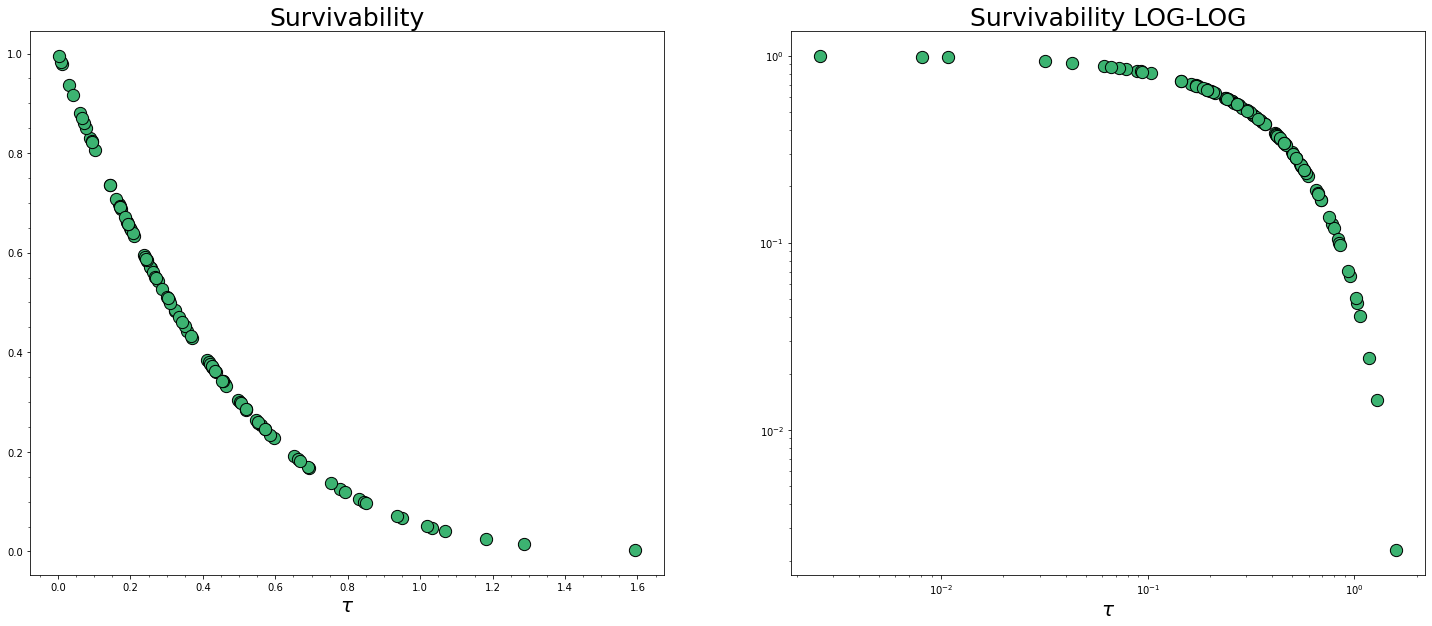

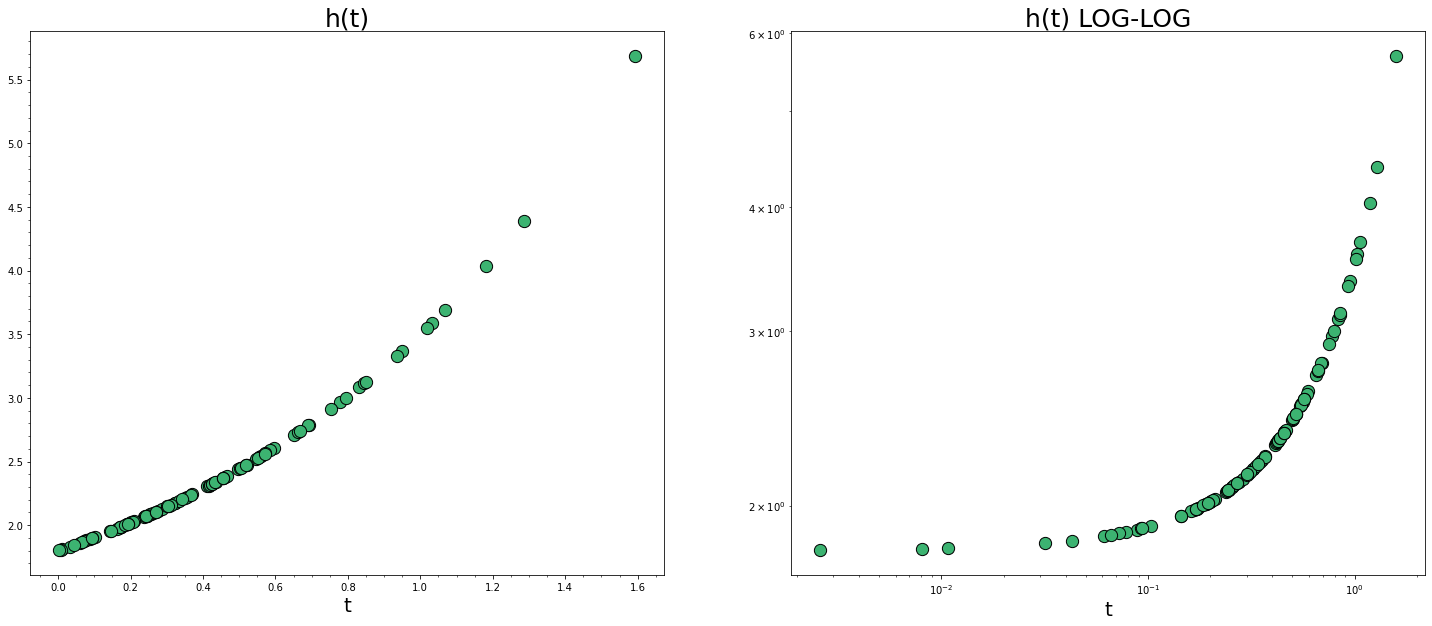

In [24]:
# PLOT s(t)
fig, ax = plt.subplots(1,2 , figsize=(25, 10))
ax[0].scatter(sim_t, CDF(sim_t), s=150, color='mediumseagreen', edgecolor='black')
ax[0].set_title('Survivability', fontsize=25)
ax[0].set_xlabel('$\\tau$', fontsize = 20)
ax[0].minorticks_on()

ax[1].scatter(sim_t, CDF(sim_t), s=150, color='mediumseagreen', edgecolor='black')
ax[1].set_title('Survivability LOG-LOG', fontsize=25)
ax[1].set_xlabel('$\\tau$', fontsize = 20)
ax[1].minorticks_on()
ax[1].set_xscale('log')
ax[1].set_yscale('log')

# PLOT h(t)
fig, ax = plt.subplots(1,2 , figsize=(25, 10))
ax[0].scatter(sim_t, h(sim_t), s=150, color='mediumseagreen', edgecolor='black')
ax[0].set_title('h(t)', fontsize=25)
ax[0].set_xlabel('t', fontsize = 20)
ax[0].minorticks_on()

ax[1].scatter(sim_t, h(sim_t), s=150, color='mediumseagreen', edgecolor='black')
ax[1].set_title('h(t) LOG-LOG', fontsize=25)
ax[1].set_xlabel('t', fontsize = 20)
ax[1].minorticks_on()
ax[1].set_xscale('log')
ax[1].set_yscale('log')

## Forward propagation
At this point, given the time series of the survival times, we can forward propagate the evolution of a single cell, according to the following procedure:

1. Start with the initial size $x_b$
2. Propagate using the equation for $x(t)$ up to the first division time
3. Divide the cell's size by 2 (assuming the cell divides equally in two parts)
4. Repeat the last 2 points for all division times generated


In [ ]:
while condition:
    pass

# References
- Held J, Lorimer T, Pomati F, Stoop R, Albert C. Second-order phase transition in phytoplankton trait dynamics. Chaos. 2020;30(5):053109. doi:10.1063/1.5141755 
- https://emcee.readthedocs.io/en/stable/

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=52dba48d-3798-4665-95fc-01a96804955b' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>